In [2]:
% pylab inline
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
from utils import nn_l2_mean
slim = tf.contrib.slim
ds = tf.contrib.distributions
from universal_divergence import estimate

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Populating the interactive namespace from numpy and matplotlib


/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [1]:
cd ..

/home/data/bruno/diff-game


In [3]:
tf.reset_default_graph()

In [4]:
tf.set_random_seed(42)
np.random.seed(42)


### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [5]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [6]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-4.5,4.5,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Hyperparam

In [17]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=20000,
    viz_every=2000,
    z_dim=256,
    x_dim=2,
    optimizer='rms-georgios', # rmsprop sgd sga
    lambd=1e-3
)

## Function for Symplectic gradient adjustment

## Construct model and training ops

In [18]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

if params['optimizer'] == 'rmsprop':
    print('sgd')
    g_train_opt = tf.train.RMSPropOptimizer(params['gen_learning_rate'])
    d_train_opt = tf.train.RMSPropOptimizer(params['disc_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    train_op = tf.group(g_train_op, d_train_op)

elif params['optimizer'] == 'sgd':    
    d_train_opt = tf.train.GradientDescentOptimizer(params['gen_learning_rate'])
    g_train_opt = tf.train.GradientDescentOptimizer(params['gen_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    train_op = tf.group(d_train_op,g_train_op)

elif params['optimizer'] == 'georgios': 
    print('georgios')

#     optimizer = tf.train.GradientDescentOptimizer(params['disc_learning_rate'])
    d_grads = tf.gradients(loss, disc_vars)
    g_grads = tf.gradients(-loss, gen_vars)
    
    variables = disc_vars + gen_vars
    grads = d_grads + g_grads
    
    var_updates = []
    for grad, var in zip(grads, variables):
        var_updates.append(var.assign_sub(params['disc_learning_rate'] * grad - params['lambd'] * var))
    train_op = tf.group(*var_updates)
    
elif params['optimizer'] == 'rms-georgios': 
    print('rms-georgios')
    d_opt = tf.train.RMSPropOptimizer(learning_rate=params['disc_learning_rate'])
    g_opt = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'])
    
    optimizer = tf.train.RMSPropOptimizer(params['disc_learning_rate'], use_locking=True)
    
    d_grads = tf.gradients(loss, disc_vars)
    g_grads = tf.gradients(-loss, gen_vars)
    
    variables = disc_vars + gen_vars
    grads = d_grads + g_grads
    
    apply_vec = [(g + params['lambd'] * v, v)for (g, v) in zip(grads, variables)]
    
    with tf.control_dependencies([g for (g, v) in apply_vec]):
        train_op = optimizer.apply_gradients(apply_vec)
    
#     with tf.control_dependencies([g for (g, v) in apply_vec]):
#         train_op = optimizer.apply_gradients(apply_vec)
    

# elif params['optimizer'] == 'consensus': 
#     print('consensus')
#     d_opt = tf.train.RMSPropOptimizer(learning_rate=params['disc_learning_rate'])
#     g_opt = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'])
    
#     optimizer = tf.train.RMSPropOptimizer(params['disc_learning_rate'], use_locking=True)

    
# #     dvs = d_opt.compute_gradients(loss, var_list=disc_vars)
# #     gvs = g_opt.compute_gradients(-loss, var_list=gen_vars)
    
#     d_grads = tf.gradients(loss, disc_vars)
#     g_grads = tf.gradients(-loss, gen_vars)
    
#     variables = disc_vars + gen_vars
#     grads = d_grads + g_grads
    

#     # Reguliarizer
#     reg = 0.5 * sum(tf.reduce_sum(tf.square(g)) for g in grads)
#     # Jacobian times gradiant
#     Jgrads = tf.gradients(reg, variables)
    
#     apply_vec = [(g + params['reg_w'] * Jg, v)for (g, Jg, v) in zip(grads, Jgrads, variables) if Jg is not None]
    
#     with tf.control_dependencies([g for (g, v) in apply_vec]):
#         train_op = optimizer.apply_gradients(apply_vec)

rms-georgios


## Train

In [19]:
# config = tf.ConfigProto(device_count={'GPU': 0})
# config.gpu_options.allow_growth = True
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/20001 [00:00<?, ?it/s]

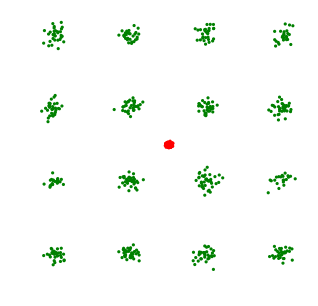

  0%|          | 7/20001 [00:05<4:40:41,  1.19it/s] 

dist =  21.04162288246847
kl =  12.122974423415862


  1%|          | 215/20001 [00:13<21:13, 15.53it/s] 

dist =  23.280899541871435
kl =  6.685567478102568


  2%|▏         | 408/20001 [00:23<18:37, 17.53it/s]

dist =  29.25477711716788
kl =  7.956076977130035


  3%|▎         | 613/20001 [00:31<16:44, 19.31it/s]

dist =  23.593354635708796
kl =  7.260070792469119


  4%|▍         | 813/20001 [00:39<15:41, 20.37it/s]

dist =  11.19256466909055
kl =  4.311422468830392


  5%|▌         | 1009/20001 [00:47<14:51, 21.30it/s]

dist =  0.030890740848128442
kl =  2.0656188889855467


  6%|▌         | 1215/20001 [00:55<14:12, 22.05it/s]

dist =  0.019428031554978572
kl =  1.974801770406144


  7%|▋         | 1411/20001 [01:02<13:47, 22.46it/s]

dist =  0.021038196148782662
kl =  2.1104090451524145


  8%|▊         | 1607/20001 [01:10<13:23, 22.88it/s]

dist =  0.018902296912106386
kl =  1.866610803979794


  9%|▉         | 1813/20001 [01:17<13:01, 23.26it/s]

dist =  0.017676015002546137
kl =  1.9979473371534149


 10%|▉         | 1994/20001 [01:20<12:05, 24.80it/s]

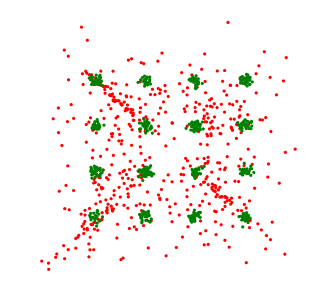

 10%|█         | 2008/20001 [01:25<12:48, 23.42it/s]

dist =  0.019891124063794167
kl =  2.0568610867900605


 11%|█         | 2211/20001 [01:33<12:33, 23.60it/s]

dist =  0.017963874255223392
kl =  2.1208571816933914


 12%|█▏        | 2415/20001 [01:41<12:18, 23.81it/s]

dist =  0.01827527797335459
kl =  2.089906427108079


 13%|█▎        | 2612/20001 [01:49<12:08, 23.88it/s]

dist =  0.023697882364122003
kl =  2.382344839887955


 14%|█▍        | 2812/20001 [01:57<11:55, 24.03it/s]

dist =  0.01941197181647049
kl =  2.4194566658629566


 15%|█▌        | 3010/20001 [02:05<11:46, 24.05it/s]

dist =  0.0224026787391282
kl =  2.5714624605895087


 16%|█▌        | 3208/20001 [02:13<11:36, 24.11it/s]

dist =  0.019727477785885104
kl =  2.6318921333112244


 17%|█▋        | 3413/20001 [02:20<11:25, 24.21it/s]

dist =  0.02250791493752056
kl =  2.5798259895823157


 18%|█▊        | 3607/20001 [02:29<11:19, 24.12it/s]

dist =  0.01663567155147361
kl =  2.4116944543765597


 19%|█▉        | 3812/20001 [02:37<11:08, 24.20it/s]

dist =  0.019794719988535336
kl =  2.259694615685229


 20%|█▉        | 3995/20001 [02:40<10:41, 24.97it/s]

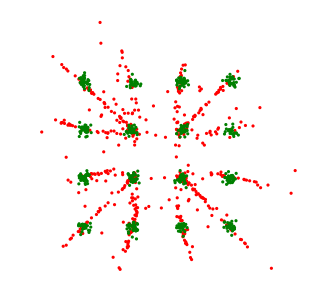

 20%|██        | 4009/20001 [02:45<10:58, 24.28it/s]

dist =  0.018100941315925104
kl =  2.035521976223887


 21%|██        | 4211/20001 [02:52<10:48, 24.36it/s]

dist =  0.019071822882445334
kl =  2.1629097613932964


 22%|██▏       | 4407/20001 [03:01<10:41, 24.30it/s]

dist =  0.01914317699634675
kl =  1.9099652057023762


 23%|██▎       | 4608/20001 [03:10<10:35, 24.24it/s]

dist =  0.03503489449818036
kl =  2.0625741651627973


 24%|██▍       | 4807/20001 [03:17<10:25, 24.29it/s]

dist =  0.025937337445433754
kl =  1.6612097703252746


 25%|██▌       | 5011/20001 [03:25<10:14, 24.38it/s]

dist =  0.03239367190194522
kl =  1.637623211987679


 26%|██▌       | 5207/20001 [03:33<10:07, 24.34it/s]

dist =  0.012710381996403066
kl =  1.1764302288896658


 27%|██▋       | 5408/20001 [03:41<09:59, 24.36it/s]

dist =  0.029676917511184453
kl =  1.5132400657985463


 28%|██▊       | 5613/20001 [03:49<09:49, 24.41it/s]

dist =  0.04268096614933734
kl =  2.078717171710968


 29%|██▉       | 5809/20001 [03:58<09:41, 24.40it/s]

dist =  0.015332555668806536
kl =  1.2777485543562221


 30%|██▉       | 5994/20001 [04:01<09:23, 24.87it/s]

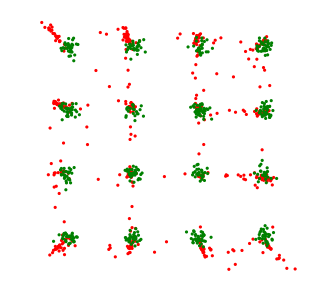

 30%|███       | 6007/20001 [04:05<09:32, 24.44it/s]

dist =  0.016047142366587365
kl =  1.3872736702809632


 31%|███       | 6213/20001 [04:13<09:23, 24.47it/s]

dist =  0.012276997411486865
kl =  1.1223289599763748


 32%|███▏      | 6407/20001 [04:22<09:16, 24.44it/s]

dist =  0.013193413104612218
kl =  1.3024238883779016


 33%|███▎      | 6609/20001 [04:30<09:07, 24.46it/s]

dist =  0.013534803345362188
kl =  1.1273259055854044


 34%|███▍      | 6809/20001 [04:38<08:58, 24.48it/s]

dist =  0.016380719667216565
kl =  1.042730530155617


 35%|███▌      | 7010/20001 [04:46<08:50, 24.50it/s]

dist =  0.011710165177252976
kl =  0.962085111694543


 36%|███▌      | 7213/20001 [04:53<08:41, 24.54it/s]

dist =  0.014170335066399123
kl =  1.090193635701401


 37%|███▋      | 7409/20001 [05:01<08:32, 24.57it/s]

dist =  0.018262264997372626
kl =  1.711037624448513


 38%|███▊      | 7612/20001 [05:09<08:23, 24.62it/s]

dist =  0.014962026203410828
kl =  1.5160958900541424


 39%|███▉      | 7808/20001 [05:17<08:15, 24.61it/s]

dist =  0.011423330953308025
kl =  0.9028982249437902


 40%|███▉      | 7995/20001 [05:19<07:59, 25.01it/s]

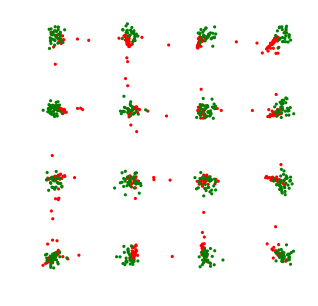

 40%|████      | 8011/20001 [05:25<08:06, 24.63it/s]

dist =  0.016857772134318733
kl =  1.551454205058107


 41%|████      | 8209/20001 [05:32<07:58, 24.67it/s]

dist =  0.02547577460433864
kl =  1.7293141502467946


 42%|████▏     | 8407/20001 [05:40<07:49, 24.70it/s]

dist =  0.029122038429690217
kl =  1.979863914527026


 43%|████▎     | 8611/20001 [05:48<07:40, 24.71it/s]

dist =  0.014571966353935546
kl =  1.0277177151391927


 44%|████▍     | 8812/20001 [05:56<07:32, 24.72it/s]

dist =  0.022543390753661203
kl =  1.4760760134121855


 45%|████▌     | 9011/20001 [06:04<07:24, 24.72it/s]

dist =  0.016233659339999745
kl =  1.341923758677511


 46%|████▌     | 9214/20001 [06:12<07:16, 24.73it/s]

dist =  0.016692331859545228
kl =  1.1900641380568389


 47%|████▋     | 9411/20001 [06:20<07:08, 24.72it/s]

dist =  0.019264917238948746
kl =  1.7440761242298533


 48%|████▊     | 9606/20001 [06:28<07:00, 24.72it/s]

dist =  0.01854292934823921
kl =  1.5062104217492647


 49%|████▉     | 9809/20001 [06:37<06:52, 24.69it/s]

dist =  0.02753946658449441
kl =  1.6113169841403825


 50%|████▉     | 9995/20001 [06:39<06:40, 25.00it/s]

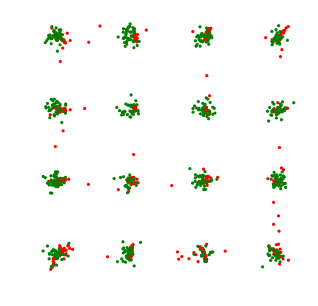

 50%|█████     | 10011/20001 [06:45<06:44, 24.68it/s]

dist =  0.015157544397628024
kl =  1.1444679052471787


 51%|█████     | 10215/20001 [06:53<06:36, 24.67it/s]

dist =  0.019358997645223055
kl =  1.4706487698168043


 52%|█████▏    | 10415/20001 [07:03<06:29, 24.62it/s]

dist =  0.017812120114578445
kl =  1.6580365964266632


 53%|█████▎    | 10608/20001 [07:10<06:21, 24.62it/s]

dist =  0.01429688356377057
kl =  1.0922610048832055


 54%|█████▍    | 10813/20001 [07:19<06:13, 24.61it/s]

dist =  0.014693517752671784
kl =  0.993689159350065


 55%|█████▌    | 11010/20001 [07:27<06:05, 24.58it/s]

dist =  0.020348063322392616
kl =  1.479711825424491


 56%|█████▌    | 11208/20001 [07:36<05:57, 24.57it/s]

dist =  0.019432223566998866
kl =  1.4287803867765207


 57%|█████▋    | 11408/20001 [07:44<05:49, 24.58it/s]

dist =  0.016948251681448857
kl =  1.2437461393156481


 58%|█████▊    | 11608/20001 [07:52<05:41, 24.57it/s]

dist =  0.018447696800669097
kl =  1.432027905765572


 59%|█████▉    | 11807/20001 [08:00<05:33, 24.59it/s]

dist =  0.015632398097940634
kl =  1.25827571649303


 60%|█████▉    | 11995/20001 [08:02<05:22, 24.85it/s]

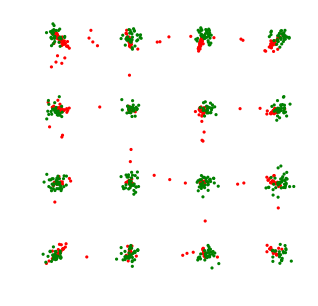

 60%|██████    | 12012/20001 [08:08<05:25, 24.58it/s]

dist =  0.020205038647869874
kl =  1.8271533704967422


 61%|██████    | 12210/20001 [08:16<05:16, 24.59it/s]

dist =  0.019179827838259094
kl =  1.259341580315973


 62%|██████▏   | 12409/20001 [08:24<05:08, 24.57it/s]

dist =  0.01581914664663525
kl =  1.3213742355247171


 63%|██████▎   | 12612/20001 [08:33<05:00, 24.55it/s]

dist =  0.02256073566781462
kl =  1.4186962254980613


 64%|██████▍   | 12811/20001 [08:41<04:52, 24.55it/s]

dist =  0.020465478239700366
kl =  1.3951049138191816


 65%|██████▌   | 13008/20001 [08:49<04:44, 24.56it/s]

dist =  0.024053330814428665
kl =  1.5198582691552303


 66%|██████▌   | 13208/20001 [08:57<04:36, 24.56it/s]

dist =  0.03038031657666557
kl =  1.881022250386604


 67%|██████▋   | 13414/20001 [09:05<04:28, 24.57it/s]

dist =  0.021883626235665216
kl =  1.6567099617566874


 68%|██████▊   | 13611/20001 [09:13<04:19, 24.58it/s]

dist =  0.030715315506153956
kl =  1.913977555040431


 69%|██████▉   | 13815/20001 [09:21<04:11, 24.60it/s]

dist =  0.023960132230756177
kl =  2.1188345636641848


 70%|██████▉   | 13994/20001 [09:23<04:02, 24.82it/s]

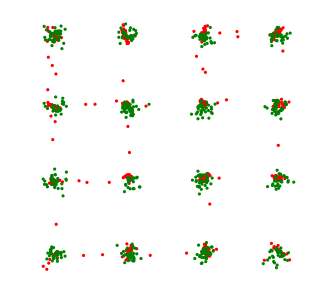

 70%|███████   | 14010/20001 [09:29<04:03, 24.59it/s]

dist =  0.019834995529551296
kl =  1.1163098606970507


 71%|███████   | 14213/20001 [09:38<03:55, 24.57it/s]

dist =  0.017122157352598144
kl =  1.3568630794328316


 72%|███████▏  | 14414/20001 [09:46<03:47, 24.56it/s]

dist =  0.021358388122739186
kl =  1.4780625800188538


 73%|███████▎  | 14609/20001 [09:54<03:39, 24.56it/s]

dist =  0.02326782495243225
kl =  1.4111807815813058


 74%|███████▍  | 14813/20001 [10:03<03:31, 24.56it/s]

dist =  0.021927536711313814
kl =  1.670987881692807


 75%|███████▌  | 15014/20001 [10:11<03:22, 24.57it/s]

dist =  0.019234721332830922
kl =  1.2571974023476828


 76%|███████▌  | 15211/20001 [10:19<03:15, 24.56it/s]

dist =  0.01899821800722519
kl =  1.2194811566204757


 77%|███████▋  | 15415/20001 [10:27<03:06, 24.57it/s]

dist =  0.03777330813816673
kl =  2.4831787528262885


 78%|███████▊  | 15614/20001 [10:35<02:58, 24.57it/s]

dist =  0.03138215075536005
kl =  1.9673963032860944


 79%|███████▉  | 15812/20001 [10:43<02:50, 24.56it/s]

dist =  0.021651563373127024
kl =  1.579361696443693


 80%|███████▉  | 15997/20001 [10:46<02:41, 24.74it/s]

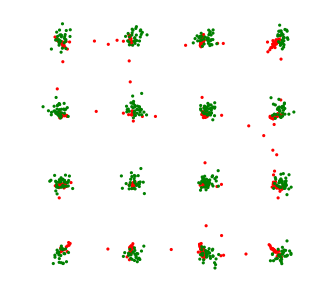

 80%|████████  | 16013/20001 [10:51<02:42, 24.56it/s]

dist =  0.024558812773275446
kl =  1.881898056433521


 81%|████████  | 16208/20001 [10:59<02:34, 24.59it/s]

dist =  0.02434449689486365
kl =  1.4842290086916634


 82%|████████▏ | 16408/20001 [11:06<02:25, 24.62it/s]

dist =  0.027237858688567176
kl =  1.5676456897439368


 83%|████████▎ | 16615/20001 [11:13<02:17, 24.66it/s]

dist =  0.033295466691729475
kl =  2.039805834942387


 84%|████████▍ | 16809/20001 [11:20<02:09, 24.71it/s]

dist =  0.02619825191668553
kl =  1.5581175692768348


 85%|████████▌ | 17014/20001 [11:27<02:00, 24.76it/s]

dist =  0.022094703471429642
kl =  1.5973840974425038


 86%|████████▌ | 17211/20001 [11:34<01:52, 24.79it/s]

dist =  0.019291055618101453
kl =  1.3030560739385844


 87%|████████▋ | 17414/20001 [11:41<01:44, 24.83it/s]

dist =  0.018089160601496755
kl =  1.3752720363716082


 88%|████████▊ | 17609/20001 [11:49<01:36, 24.83it/s]

dist =  0.026409710472969344
kl =  1.9639268334429913


 89%|████████▉ | 17809/20001 [11:56<01:28, 24.87it/s]

dist =  0.03003717697646202
kl =  1.6698182636241086


 90%|████████▉ | 17995/20001 [11:58<01:20, 25.05it/s]

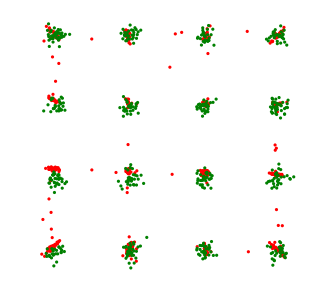

 90%|█████████ | 18011/20001 [12:03<01:19, 24.90it/s]

dist =  0.02452441409797947
kl =  1.7280133169597103


 91%|█████████ | 18210/20001 [12:10<01:11, 24.93it/s]

dist =  0.02583630833454867
kl =  1.6103841191882107


 92%|█████████▏| 18410/20001 [12:18<01:03, 24.94it/s]

dist =  0.02422003535796959
kl =  1.6340044692746871


 93%|█████████▎| 18608/20001 [12:25<00:55, 24.96it/s]

dist =  0.022983414587573688
kl =  1.5654770502669169


 94%|█████████▍| 18808/20001 [12:32<00:47, 24.99it/s]

dist =  0.021290048679646265
kl =  1.4023706801178344


 95%|█████████▌| 19012/20001 [12:39<00:39, 25.03it/s]

dist =  0.021904300612384103
kl =  1.4908252082178075


 96%|█████████▌| 19213/20001 [12:46<00:31, 25.05it/s]

dist =  0.01855794445556138
kl =  1.3915783705248361


 97%|█████████▋| 19413/20001 [12:53<00:23, 25.09it/s]

dist =  0.026383163715588315
kl =  1.574915299852269


 98%|█████████▊| 19608/20001 [13:01<00:15, 25.09it/s]

dist =  0.022059352496395557
kl =  1.4997323327838004


 99%|█████████▉| 19810/20001 [13:08<00:07, 25.12it/s]

dist =  0.022003494704119764
kl =  1.6034107152291015


100%|█████████▉| 19993/20001 [13:10<00:00, 25.28it/s]

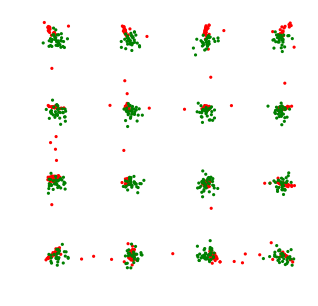

100%|██████████| 20001/20001 [13:15<00:00, 25.14it/s]

dist =  0.024477434367621922
kl =  1.6142527341220876


In [20]:
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
nn_every = 200
y_ref = sess.run( data)
nn_dist = []
nn_kl =[]
for i in tqdm(range(params['max_iter']+1)):
#     f, _, _ = sess.run([[loss], g_train_op, d_train_op])
    f, _= sess.run([[loss], train_op])

    fs.append(f)
    if (i) % viz_every == 0:
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], c='r', edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
#         plt.xlim([-5.5, 5.5])
#         plt.ylim([-5.5, 5.5])
        axis('off')
        show()
        
    if (i) % nn_every == 0:
        x = np.vstack([sess.run(samples) for _ in range(n_batches_viz)])
        l2nn = nn_l2_mean(x,y_ref)
        kl =estimate(x, y_ref,k=1)
        nn_dist.append(l2nn)
        nn_kl.append(kl)
        print('dist = ', l2nn)
        print('kl = ', kl)

    

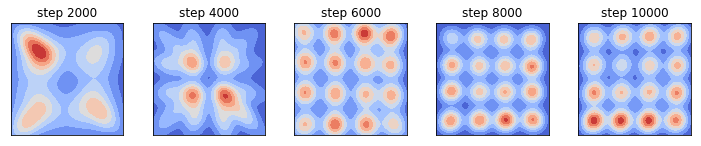

In [32]:
np_samples_ = np_samples[1:6]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
#     ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-6,6]]*2)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='coolwarm',bw=.40, n_levels=8, clip=[[-6,6]]*2)
    ax2.set(xlim=(-6, 6), aspect="equal")
#     ax2.collections[0].set_alpha(0)
#     ax2.set_axis_bgcolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%((i+1)*viz_every))
gcf().tight_layout()
fig = plt.gcf()
fig.savefig('./GeorgiosOptimizer/l2_georgios_l1e3.png', dpi=200)

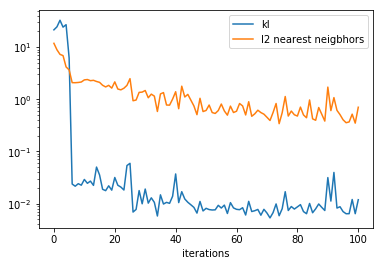

In [14]:
plt.semilogy(nn_dist)
plt.semilogy(nn_kl)
plt.legend(['kl','l2 nearest neigbhors'])
xlabel('iterations')
plt.show()

In [12]:
np.save('plot_con_kl',nn_kl)
np.save('plot_con_nn',nn_dist)

In [31]:
ls

conscensus-gan.ipynb         OMD-1D-TOY-Example.ipynb
data/                        optimizers.py
figures/                     panayoGAN.ipynb
gan_mnist.ipynb              plot_con_kl.npy
GeorgiosOptimizer/           plot_con_nn.npy
k_gan.py                     plot_divergence.ipynb
kl_rms_ema_enabledFalse.npy  plot_metrics.ipynb
kl_rms_ema_enabledTrue.npy   plots/
l2_georgios_l1e3.png         __pycache__/
l2_georgios_l1e4.png         rmsprop-gan.ipynb
log_mnist/                   sampler.py
MNIST_data/                  sga-gan.ipynb
mnist_experiments.ipynb      sga_mnist/
mnist_model.py               utils.py
nn_rms_ema_enabledFalse.npy  WGANs-toy-Copy-Sauvegarde.ipynb
nn_rms_ema_enabledTrue.npy   WGANs-toy.ipynb
npy/                         YasinFigures/
